In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Camera Calibration

In [2]:
# Arrays to store object points and image points
objpoints = [] # 3d points of the chessboard object in real world space
imgpoints = [] # 2d points in image plane.


# prepare object 3d points
objp = np.zeros((6*9,3), np.float32)
# make coordinates for a given grid size of 9x6
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

#list of calibration images (Using os instead of glob, as glob returns empty list)
images = os.listdir("cam_cal/" )

# Chessboard corners
for fname in images:
    img = mpimg.imread("cam_cal/%s" %(fname))
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)


    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
# cv2.calibrateCamera returns camera matrix, distortion coefficients, rotation and translation vectors
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


##  Functions

In [3]:
# Image Undistortion
def undistort(img):
     return cv2.undistort(img, mtx, dist, None, mtx)

# S-channel Color threshold
def color_thresh (img, thresh = (100,255)):
    
    # RGB to HLS conversion
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # Extracting S-channel info
    S = hls[:,:,2]
    
    #Thresholding S-channel
    col_binary = np.zeros_like(S)
    col_binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    return col_binary


# Gradient Absolute (Sobel x/y) threshold
def abs_thresh(img, orient='x', sobel_kernel = 15, thresh=(20,150)):
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # absolute gradient (derivative in x or y direction)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel) # Calculate the derivative in the x direction 
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel) # Calculate the derivative in the y direction 
        
    abs_sobel = np.absolute(sobel) 
    
    #normilazation then rescaling image to 8-bit
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel)) 

    #Thresholding absolute gradient
    abs_binary = np.zeros_like(scaled_sobel)
    abs_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return abs_binary

# Gradient direction threshold
def dir_thresh(img, sobel_kernel=15, thresh=(0.4,1)):

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # gradient in x and y direction
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    
    # Direction of gradient using inverse tangent 
    graddir = np.arctan2(abs_sobely, abs_sobelx) 
    
    # Thresholding gradient direction
    dir_binary = np.zeros_like(graddir)
    dir_binary[(graddir >= thresh[0]) & (graddir <= thresh[1])] = 1

    return dir_binary

# Gradient magnitude threshold
def mag_thresh(img, sobel_kernel=19, thresh=(45,255)):

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # gradient in x and y direction
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescaling image 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    # Thresholding gradient magnitude
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    return mag_binary


# Gradient Combined threshold

def comb_thresh (undist):
    
    k_abs = 15 # Absolute gradient kernel size
    k_dir = 15 # Direction gradient kernel size
    k_mag = 19 # Magnitude gradient kernel size

    col_thr_r = (100,255) # Color threshold range
    abs_thr_r = (20,150) # Absolute Gradient threshold range
    mag_thr_r = (45,255) # Magnitude Gradient  threshold range
    dir_thr_r = (0.4,1) # Direction Gradient threshold range
    
    col_binary = color_thresh (undist, col_thr_r)
    abs_binary = abs_thresh(undist, 'x', k_abs, abs_thr_r)
    dir_binary = dir_thresh(undist, k_dir, dir_thr_r)
    mag_binary = mag_thresh(undist, k_mag, mag_thr_r)

    # Combining Absolute, Magnitude, Direction and Color thresholding
    # Using logical operations
    comb_binary = np.zeros_like(dir_binary)
    comb_binary[((abs_binary == 1) & (mag_binary == 1)) | (col_binary == 1) | \
                ((mag_binary == 1) & (dir_binary == 1))] = 1
      
    return comb_binary

# Perspective transformation (Warping to a Bird-eye view)
def pers_tranform(image):
    
    undist = undistort(image)
    img_size = (undist.shape[1], undist.shape[0])
    
    # Order of image points
    # top_left (1) - top_right (2) - bottom_right (3) - bottom_left (4)

    # Image source points (to be transformed)
    src = np.float32([[588, 451],
                      [690, 451],
                      [1055, 678],
                      [251, 678]])
    
    # to compensate for maintaining aspect ratios
    offset = 250
    
    # Destination ponts (for source points to be mapped into)
    dst = np.float32([[offset, 0],
                      [img_size[0]-offset, 0], 
                      [img_size[0]-offset, img_size[1]], 
                      [offset, img_size[1]]])
    
    # getPerspectiveTransform to calculate transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # inverse transformation matrix (swapped src and dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # warping of perspective
    warp = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    # inverse warping
    inv_warp = cv2.warpPerspective(image, Minv, img_size, flags=cv2.INTER_LINEAR)
    return (warp, M, Minv), (src, dst)

# left and right lanes pixels
def find_lane_pixels(binary_warped):
    # histogram of image bottom half
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)    
 
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Peaks of histogram left and right sides as a starting point 
    # For a lane existence
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint


    # Sliding windows
    nwindows = 9
    # Window width margin
    margin = 100
    # Minimum threshold for window recentering
    minpix = 50

    # Windows height
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Nonzero pixels 
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions 
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Left and right lane pixels lists
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # y coordinates window boundries
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # x coordinates window boundries
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        
        # Nonzero pixels 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        

        # Appending Nonzero pixels to Left and right lane lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # recentering next window due to min threshold of pixels found
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Indices arrays concatenation
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # second order polynomial for left and right lane
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Polynomials plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    # Visualization 
    #converting to correct data type (int) for lanes visualization
    out_img = out_img.astype(np.uint8)*255
    
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    return (left_fit, right_fit),(left_fitx, right_fitx), out_img

# Search from prior method of polynomials fitting
# Using previous sliding windows information
def look_ahead_poly(prev_poly, binary_warped):
    
    # Width of search around previous polynomial
    margin = 100

    #indexing old polynomial coefficients
    left_fit = prev_poly[0]
    right_fit = prev_poly[1]
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #finding x, y values for fitting the previous polynomial using
    #previous polynomial coefficients
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
   
    # Nonzero pixels area based on activated x-values
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    #fitting new polynomials based on new x and y pixel values
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    img_shape = binary_warped.shape
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    # Polynomials plotting
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
   
    # Search area visualization
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Red left lane and blue right lane
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # x and y points recasting for cv2.fillyPoly() to illustrate search area
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw search area as a green polynomial with width of margin
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result, (left_fitx, right_fitx)

# Measuring lanes curvature 
def measure_curvature(new_x_pixels):

    
    # x and y conversion ratios, from pixels to meters
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700
    
    # y points to cover the 720 pixels of image height
    ploty = np.linspace(0, 719, num=720) 
    
    left_fitx = new_x_pixels[0]
    right_fitx = new_x_pixels[1]
    
    # radius measuring point is image bottom
    y_eval = np.max(ploty)

    # curves coefficients in meters
    left_fit = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2)
    right_fit = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)

    # Radius of curve calculation
    left_rad = np.int(((1+(2*left_fit[0]*y_eval*ym_per_pix +left_fit[1])**2)**1.5)/np.absolute(2*left_fit[0]))  
    right_rad = np.int(((1+(2*right_fit[0]*y_eval*ym_per_pix +right_fit[1])**2)**1.5)/np.absolute(2*right_fit[0]))
    
    return left_rad, right_rad

# Calculation of car position offset w.r.t lane center
def offset_calc(new_x_pixels):
    
    xm_per_pix = 3.7/700 

    left_x = new_x_pixels[0]
    right_x= new_x_pixels[1]
    
   
    # distance difference between lanes
    diff_lane = abs(left_x[len(left_x) - 1] - right_x[len(right_x) - 1]) / 2
    
    # lane center = left lane + lane difference
    lane_cen = left_x[len(left_x) - 1] + diff_lane 
    
    # car center (equivalent to image center where camera is mounted) 
    car_cen = 1080/2

    #offset calculation
    offset_m = (car_cen - lane_cen) * xm_per_pix
    direc =''
    
    # determination of car position (left/right) w.r.t. lane center
    if offset_m < 0: 
        direc = 'left'
        offset_m = abs(round(offset_m, 2))
    elif offset_m > 0:
        direc = 'right'
        offset_m = abs(round(offset_m, 2))
    
    return offset_m, direc

# Lanes region
def lanes_region(undist, warped, Minv, new_x_pixels):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fitx = new_x_pixels[0]
    right_fitx = new_x_pixels[1]
    
    # y points to cover the 720 pixels of image height
    ploty = np.linspace(0, 719, num=720)
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
    # Blending the result with the original image
    lanes_output = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return lanes_output


## Pipeline

In [4]:
def pipeline(image):
    
    # Image Undistortion
    undist = undistort(image)
    
    # Gradient Combined threshold
    comb_binary = comb_thresh (undist)
    
    # Perspective transformation
    warp_vars, img_vars  = pers_tranform(comb_binary)
    warp = warp_vars[0]
    Minv = warp_vars[2]
    
    #lane finding using sliding windows
    prev_poly, pixels_x, polyfit_img = fit_polynomial(warp)
    
    #lane finding using look-ahead filter
    look_ahead_result, new_x_pixels = look_ahead_poly(prev_poly, warp)
    
    # Measuring lanes curvature 
    left_rad, right_rad = measure_curvature(new_x_pixels)
    
    # Calculation of car position offset w.r.t lane center
    abs_offset, direc = offset_calc(new_x_pixels)

    # Lanes region
    lanes_output = lanes_region(undist, warp, Minv, new_x_pixels)
    
    # Statistics text of R_curve and offset on screen
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(lanes_output,'Radius of Curvature = '+ str(left_rad) +  \
                             '(m)', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),2,cv2.LINE_AA)

    cv2.putText(lanes_output,'Vehicle is '+ str(abs_offset) + 'm ' + str(direc) + \
                  ' of center',(50,120), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),2,cv2.LINE_AA)
    
    return lanes_output

## Test Output Images 

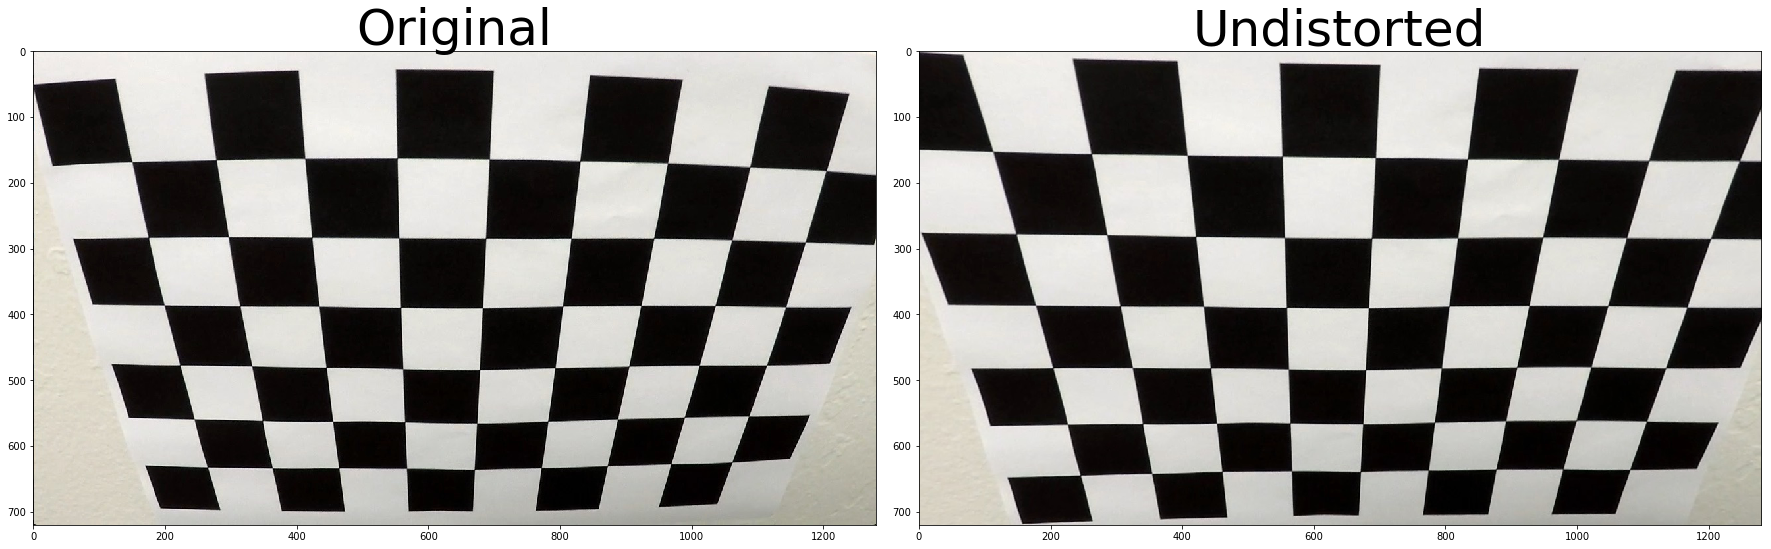

In [5]:
# Undistorted output
image = mpimg.imread("cam_cal/calibration2.jpg")
undistorted_output = undistort(image)

#drawing 2-subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original', fontsize=50)
ax2.imshow(undistorted_output)
ax2.set_title('Undistorted', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/1 undistort_output')

True

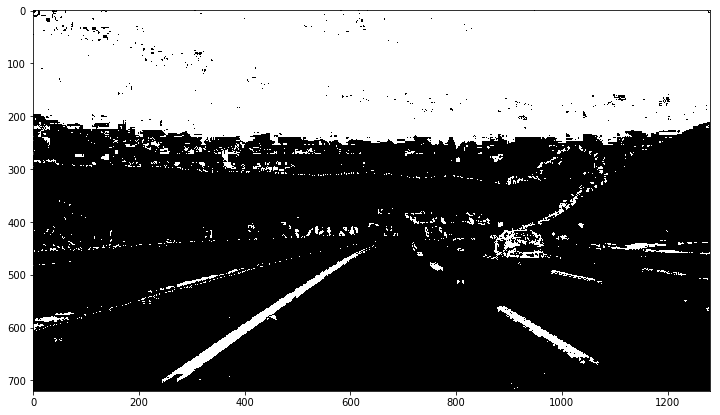

In [6]:
# Binary combination threshold output
image = mpimg.imread("test_images/test3.jpg")
undist = undistort(image)
comb_binary = comb_thresh (undist)
plt.figure(figsize=(15,7))
plt.imshow(comb_binary, cmap='gray')
cv2.imwrite('output_images/2 binary_combo.jpg' , comb_binary*255)

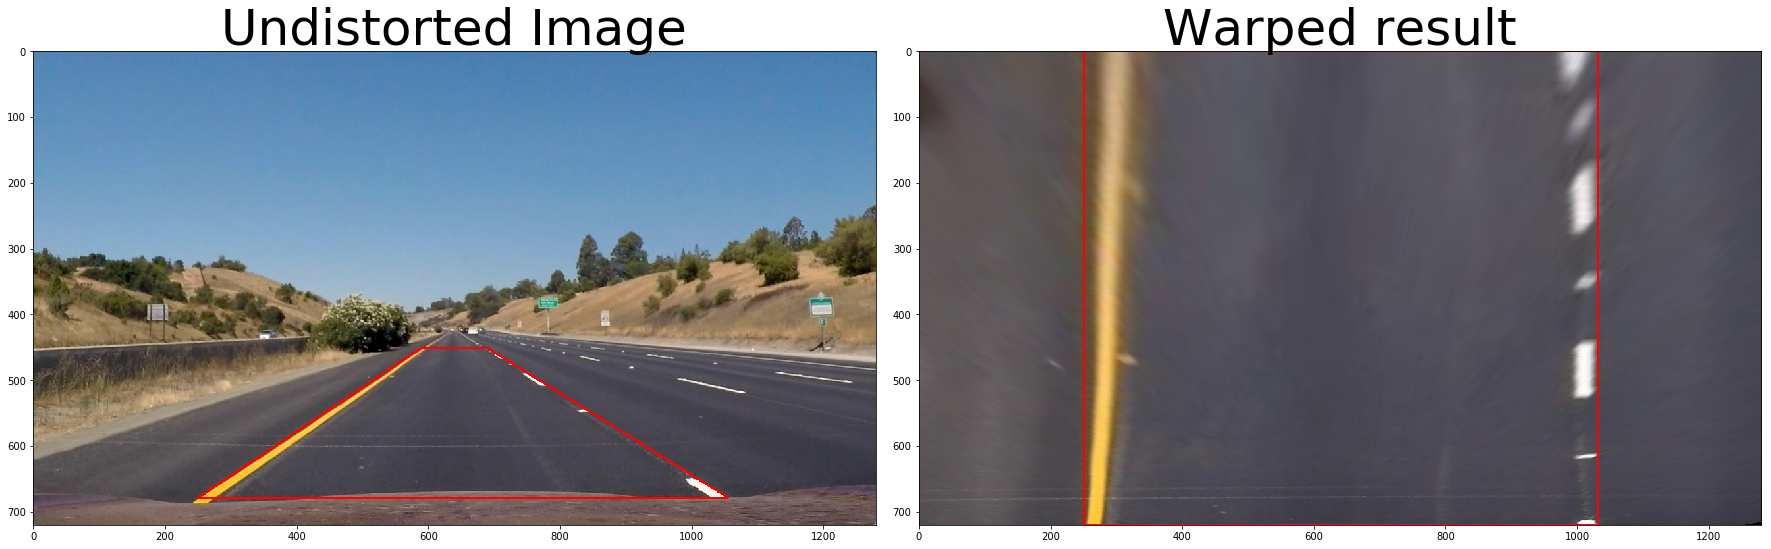

In [7]:
# Perspective Transform (Bird-eye view)
image = mpimg.imread("test_images/straight_lines1.jpg")
warp_vars, img_vars = pers_tranform(image)
warp = warp_vars[0]

#Source points extracting
src = img_vars[0]

#Destination points extracting
dst = img_vars[1]

color = [255, 0, 0]
line_width = 2

# Drawing ROI on source image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
cv2.line(image,tuple(src[0]),tuple(src[1]), color, 2)
cv2.line(image,tuple(src[1]),tuple(src[2]), color, 2)
cv2.line(image,tuple(src[2]),tuple(src[3]), color, 2)
cv2.line(image,tuple(src[3]),tuple(src[0]), color, 2)
ax1.imshow(image)
ax1.set_title('Undistorted Image', fontsize=50)

# Mapping ROI to the destination image
cv2.line(warp,tuple(dst[0]),tuple(dst[1]), color, line_width)
cv2.line(warp,tuple(dst[1]),tuple(dst[2]), color, line_width)
cv2.line(warp,tuple(dst[2]),tuple(dst[3]), color, line_width)
cv2.line(warp,tuple(dst[3]),tuple(dst[0]), color, line_width)
ax2.imshow(warp)
ax2.set_title('Warped result', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/3 warped_straight_lines')

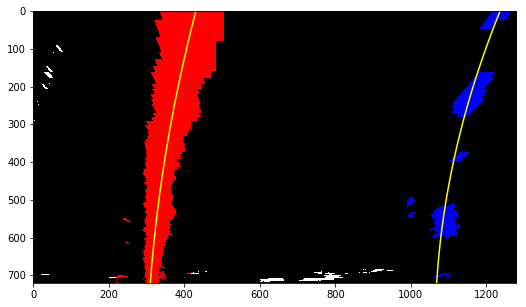

In [8]:
# Thresholding then polynomials fitting
image = mpimg.imread("test_images/test4.jpg")
undist = undistort(image)
comb_binary = comb_thresh (undist)
warp_vars, img_vars = pers_tranform(comb_binary)
warp = warp_vars[0]
prev_poly, pixels_x, polyfit_img = fit_polynomial(warp)
plt.figure(figsize=(15,5))
plt.imshow (polyfit_img)

# Plots the left and right polynomials on the lane lines
ploty = np.linspace(0, warp.shape[0]-1, warp.shape[0] )
left_fitx = pixels_x[0]
right_fitx = pixels_x[1]
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

plt.savefig('output_images/4 color_fit_lines')

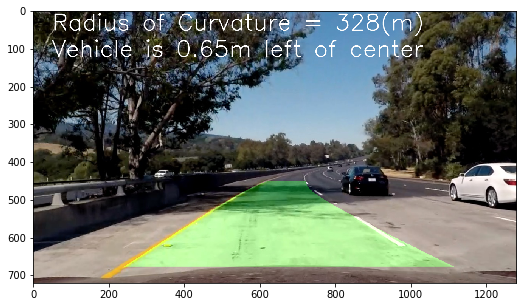

In [9]:
#Pipeline
image = mpimg.imread("test_images/test5.jpg")
lanes_output= pipeline(image)
plt.figure(figsize=(15,5))
plt.imshow (lanes_output)
plt.savefig('output_images/5 example_output')

## Video output

In [10]:
#Applying the pipeline on video input
video_output = 'output_video/project_video.mp4'
#clip1 = VideoFileClip("project_video.mp4").subclip(0,20)
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(pipeline)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_video/project_video.mp4
[MoviePy] Writing video output_video/project_video.mp4


100%|█████████▉| 1260/1261 [10:40<00:00,  1.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video.mp4 

CPU times: user 7min 50s, sys: 40.8 s, total: 8min 31s
Wall time: 10min 44s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))